In [1]:
%run common.ipynb

['LC_Type1', 'LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LC_Type1']


In [2]:
%run tuning_common.ipynb

Using TensorFlow backend


In [3]:
MODEL_SAVE_DIR = f'{DOWNSTREAM_PARTIAL_TUNE_DIR}model'

In [4]:
downstream_train_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TRAIN_FILENAME}')
downstream_test_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TEST_FILENAME}')
downstream_train_df = embed_catgorical_features(downstream_train_df, CATEGORICAL_FEATURES)
downstream_test_df = embed_catgorical_features(downstream_test_df, CATEGORICAL_FEATURES)

In [5]:
from sklearn.model_selection import train_test_split
split_train_df, split_val_df = train_test_split(downstream_train_df, test_size=0.2, shuffle=True, random_state=8)

In [6]:
split_train_tf = df_to_dataset(split_train_df[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=True, batch_size=256)
split_val_tf = df_to_dataset(split_val_df[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=False, batch_size=256)
downstream_test_input_tf = df_to_dataset(downstream_test_df[FEATURES], shuffle=False, batch_size=1)

/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [7]:
tuned_model=tf.keras.models.load_model(f'{UPSTREAM_FINETUNE_OPTUNA_DIR}model_backup')
print(tuned_model.summary())

Model: "ft_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ft_transformer_encoder (FTT  multiple                 4378472   
 ransformerEncoder)                                              
                                                                 
 mlp_block (MLPBlock)        multiple                  26313     
                                                                 
Total params: 4,404,785
Trainable params: 4,404,785
Non-trainable params: 0
_________________________________________________________________
None


## Fine tune with RMSE

### Fine tune

In [8]:
input_tensors = get_input_tensors(split_train_tf)
outputs = tuned_model(input_tensors, training=False)
new_model = tf.keras.Model(input_tensors, outputs)
print(new_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EVI (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 LC_Type1 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 LST_Day_1km (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 NDVI (InputLayer)              [(None, 1)]          0           []                               
                                                                                              

### Freeze partial layers

In [9]:
# freeze encoder, only train mlp block part
for layer in new_model.layers:
    if layer.name == 'ft_transformer':
        for layer2 in layer.layers:
            if layer2.name == 'ft_transformer_encoder':
                layer2.trainable = False
                
print(new_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EVI (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 LC_Type1 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 LST_Day_1km (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 NDVI (InputLayer)              [(None, 1)]          0           []                               
                                                                                              

In [10]:
new_data_metrics = 'val_ft_transformer_1_rmse'
mode = 'min'
new_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-5),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics= [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor=new_data_metrics, mode=mode, patience=50, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        monitor=new_data_metrics,
        mode=mode,
        filepath=MODEL_SAVE_DIR,
        save_best_only=True,
        save_freq='epoch')
]
tf.keras.backend.clear_session()
history = new_model.fit(
    split_train_tf, 
    epochs=1000, 
    validation_data=split_val_tf,
    callbacks=[callbacks]
)

Epoch 1/1000
3/4 [=====================>........] - ETA: 0s - loss: 163276864.0000 - ft_transformer_loss: 145459392.0000 - ft_transformer_1_loss: 17817470.0000 - ft_transformer_rmse: 12060.6543 - ft_transformer_1_rmse: 4221.0747

4/4 [==============================] - 11s 2s/step - loss: 163265568.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 17923546.0000 - ft_transformer_rmse: 12055.7871 - ft_transformer_1_rmse: 4233.6211 - val_loss: 170409744.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 21816332.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4670.7954
Epoch 2/1000
3/4 [=====================>........] - ETA: 0s - loss: 163343856.0000 - ft_transformer_loss: 145584256.0000 - ft_transformer_1_loss: 17759598.0000 - ft_transformer_rmse: 12065.8301 - ft_transformer_1_rmse: 4214.2139

4/4 [==============================] - 4s 1s/step - loss: 163072576.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 17730550.0000 - ft_transformer_rmse: 12055.7871 - ft_transformer_1_rmse: 4210.7661 - val_loss: 170186256.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 21592850.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4646.8105
Epoch 3/1000
3/4 [=====================>........] - ETA: 0s - loss: 160172720.0000 - ft_transformer_loss: 143294624.0000 - ft_transformer_1_loss: 16878094.0000 - ft_transformer_rmse: 11970.5732 - ft_transformer_1_rmse: 4108.2959

4/4 [==============================] - 5s 1s/step - loss: 162798048.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 17456020.0000 - ft_transformer_rmse: 12055.7881 - ft_transformer_1_rmse: 4178.0400 - val_loss: 169999232.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 21405822.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4626.6426
Epoch 4/1000
3/4 [=====================>........] - ETA: 0s - loss: 164520816.0000 - ft_transformer_loss: 147565552.0000 - ft_transformer_1_loss: 16955262.0000 - ft_transformer_rmse: 12147.6562 - ft_transformer_1_rmse: 4117.6768

4/4 [==============================] - 4s 1s/step - loss: 162271552.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 16929534.0000 - ft_transformer_rmse: 12055.7881 - ft_transformer_1_rmse: 4114.5513 - val_loss: 169841040.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 21247626.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4609.5146
Epoch 5/1000
3/4 [=====================>........] - ETA: 0s - loss: 162673264.0000 - ft_transformer_loss: 145709424.0000 - ft_transformer_1_loss: 16963846.0000 - ft_transformer_rmse: 12071.0156 - ft_transformer_1_rmse: 4118.7188

4/4 [==============================] - 5s 1s/step - loss: 162240000.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 16897992.0000 - ft_transformer_rmse: 12055.7881 - ft_transformer_1_rmse: 4110.7168 - val_loss: 169719392.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 21125988.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4596.3018
Epoch 6/1000
4/4 [==============================] - ETA: 0s - loss: 162016576.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 16674554.0000 - ft_transformer_rmse: 12055.7881 - ft_transformer_1_rmse: 4083.4487

4/4 [==============================] - 4s 1s/step - loss: 162016576.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 16674554.0000 - ft_transformer_rmse: 12055.7881 - ft_transformer_1_rmse: 4083.4487 - val_loss: 169619216.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 21025812.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4585.3911
Epoch 7/1000
3/4 [=====================>........] - ETA: 0s - loss: 162346128.0000 - ft_transformer_loss: 145768576.0000 - ft_transformer_1_loss: 16577539.0000 - ft_transformer_rmse: 12073.4658 - ft_transformer_1_rmse: 4071.5525

4/4 [==============================] - 5s 1s/step - loss: 161826000.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 16483967.0000 - ft_transformer_rmse: 12055.7871 - ft_transformer_1_rmse: 4060.0452 - val_loss: 169543312.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 20949906.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4577.1069
Epoch 8/1000
3/4 [=====================>........] - ETA: 0s - loss: 162619248.0000 - ft_transformer_loss: 145905344.0000 - ft_transformer_1_loss: 16713896.0000 - ft_transformer_rmse: 12079.1289 - ft_transformer_1_rmse: 4088.2632

4/4 [==============================] - 4s 1s/step - loss: 161859408.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 16517395.0000 - ft_transformer_rmse: 12055.7881 - ft_transformer_1_rmse: 4064.1599 - val_loss: 169489152.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 20895738.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4571.1855
Epoch 9/1000
3/4 [=====================>........] - ETA: 0s - loss: 158801376.0000 - ft_transformer_loss: 142979056.0000 - ft_transformer_1_loss: 15822331.0000 - ft_transformer_rmse: 11957.3848 - ft_transformer_1_rmse: 3977.7295

4/4 [==============================] - 4s 1s/step - loss: 161570992.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 16228978.0000 - ft_transformer_rmse: 12055.7881 - ft_transformer_1_rmse: 4028.5205 - val_loss: 169454928.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 20861522.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4567.4414
Epoch 10/1000
3/4 [=====================>........] - ETA: 0s - loss: 159992880.0000 - ft_transformer_loss: 143883984.0000 - ft_transformer_1_loss: 16108887.0000 - ft_transformer_rmse: 11995.1660 - ft_transformer_1_rmse: 4013.5879

4/4 [==============================] - 5s 1s/step - loss: 161614704.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 16272690.0000 - ft_transformer_rmse: 12055.7881 - ft_transformer_1_rmse: 4033.9421 - val_loss: 169436688.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 20843280.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4565.4443
Epoch 11/1000
4/4 [==============================] - 1s 124ms/step - loss: 161612352.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 16270336.0000 - ft_transformer_rmse: 12055.7881 - ft_transformer_1_rmse: 4033.6504 - val_loss: 169437072.0000 - val_ft_transformer_loss: 148593408.0000 - val_ft_transformer_1_loss: 20843658.0000 - val_ft_transformer_rmse: 12189.8896 - val_ft_transformer_1_rmse: 4565.4854
Epoch 12/1000
4/4 [==============================] - 1s 156ms/step - loss: 161299056.0000 - ft_transformer_loss: 145342016.0000 - ft_transformer_1_loss: 15957040.0000 

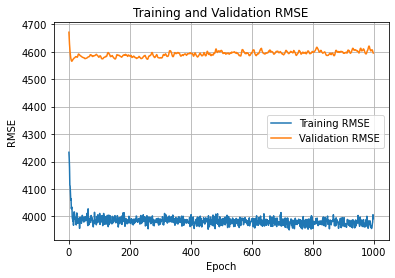

In [12]:
plot_model_history(history, 'ft_transformer_1_rmse', new_data_metrics,'RMSE')
# plot_model_history(history, 'ft_transformer_1_root_mean_squared_error', 'val_ft_transformer_1_root_mean_squared_error','RMSE')

### Load best results and predict

In [13]:
model_reload=tf.keras.models.load_model(MODEL_SAVE_DIR)

In [14]:
test_df = df_to_dataset(downstream_test_df[FEATURES], shuffle=False, batch_size=1)
predict_results = model_reload.predict(test_df)
y_pred = predict_results['output'].ravel()
modis_compare_data = get_modis_compare_data(y_pred)
get_all_metrics(y_pred, modis_compare_data[TARGET_FEATURE], downstream_test_df[TARGET_FEATURE])

/home/zheng.yant/ML-LUE/fttransformer/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


156/156 [==============================] - 2s 8ms/step
RMSE prediction: 4090.1351
RMSE MOD17: 4580.8292
R-Squared prediction: 0.5981305307351931
R-Squared MOD17: 0.49592182874680346
Max error prediction: 12817.127492187501
Max error MOD17: 15912.398000000001
Mean poisson deviance prediction: 1503.3007568992732
Mean poisson deviance MOD17: 1818.8971141518566
Mean gamma deviance prediction: 0.20582177490318515
Mean gamma deviance MOD17: 0.2402907199127134
Mean pinball loss with alpha = 0.9 prediction: 1959.9230832262872
Mean pinball loss with alpha = 0.9 MOD17: 2491.2558178084937
Mean pinball loss with alpha = 0.09999999999999998 prediction: 1137.6439229448367
Mean pinball loss with alpha = 0.09999999999999998 MOD17: 942.5344355969551


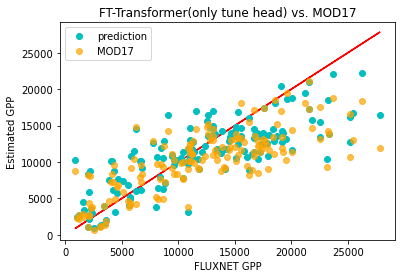

In [16]:
plot_result_distribution(downstream_test_df[TARGET_FEATURE], y_pred, modis_compare_data[TARGET_FEATURE], save_dir=f'{MODEL_RESULT_PLT_DIR}FT-Transformer_tune_head.png', title='FT-Transformer(only tune head) vs. MOD17')